In [5]:
%matplotlib notebook
from functools import partial
from os import getcwd
from os.path import join

import pprint
import matplotlib.pyplot as plt
from processor import analysis, reports
import pandas as pd

pprinter = pprint.PrettyPrinter(indent=2)
rs = reports.ReportHandler.fetch_reports(join(getcwd(), 'batch-test-reports', '1505082284'))
ip, obs_set = reports.ReportHandler.collect_observations(rs)
obs_list = sorted(list(obs_set), key=lambda obs: getattr(obs, 'day_timestamp'))

obs_list = obs_list[:reports.ReportHandler.MINIMUM_OBSERVATIONS_QTY]
rtt_sorting_key_function = analysis.observation_rtt_key_function
rtt_histogram = analysis.generate_histogram(obs_list, rtt_sorting_key_function)
bin_info_df = pd.DataFrame([{'min_rtt': min_rtt, 'max_rtt': max_rtt, 'bin_width': bin_width} 
                            for bin_width, max_rtt, min_rtt in 
                            [analysis.bin_info(hbin, rtt_sorting_key_function) 
                             for hbin in rtt_histogram]])
tau, tau_threshold = analysis.characterize_observations(obs_list, analysis.observation_rtt_key_function)
phi_function = analysis.get_phi_function(obs_list, tau)
upstream_hurst, downstream_hurst = analysis.get_hurst_values(obs_list, phi_function)
meaningful_observations = analysis.get_meaningful_observations(obs_list)
upstream_usage, downstream_usage = analysis.get_usage(meaningful_observations, phi_function)

In [9]:
upstream_time_key_function = partial(analysis.upstream_time_function, phi_function=phi_function)
downstream_time_key_function = partial(analysis.downstream_time_function, phi_function=phi_function)
upstream_histogram = analysis.generate_histogram(obs_list, upstream_time_key_function)
upstream_bin_info_df = pd.DataFrame([{'min_rtt': min_rtt, 'max_rtt': max_rtt, 'bin_width': bin_width} 
                            for bin_width, max_rtt, min_rtt in 
                            [analysis.bin_info(hbin, upstream_time_key_function) 
                             for hbin in upstream_histogram]])
downstream_histogram = analysis.generate_histogram(obs_list, downstream_time_key_function)
downstream_bin_info_df = pd.DataFrame([{'min_rtt': min_rtt, 'max_rtt': max_rtt, 'bin_width': bin_width} 
                            for bin_width, max_rtt, min_rtt in 
                            [analysis.bin_info(hbin, downstream_time_key_function) 
                             for hbin in downstream_histogram]])
downstream_bin_info_df

,bin_width,max_rtt,min_rtt
0,1.269396e+08,-7.835727e+08,-9.105123e+08
1,7.989786e+07,-7.021129e+08,-7.820107e+08
2,9.137074e+07,-6.018451e+08,-6.932158e+08
3,1.108938e+08,-4.909263e+08,-6.018201e+08
4,2.253216e+08,-2.634903e+08,-4.888118e+08
5,2.473861e+08,-3.668027e+06,-2.510541e+08
6,2.623464e+08,2.703044e+08,7.957944e+06
7,2.126531e+08,4.955890e+08,2.829358e+08
8,9.610475e+07,5.919641e+08,4.958593e+08
9,1.173770e+08,7.194325e+08,6.020555e+08


In [2]:
processed_value = analysis.process_observations(obs_list)
pprinter.pprint(processed_value)

INFO:processor.analysis.process_data_points:processing data points


{ 'downstream': { 'hurst': { 'rs': 0.76884012796454204,
                             'wavelet': 0.88595042689404568},
                  'quality': 0.8,
                  'usage': 0.6881720430107527},
  'timestamp': 1505083380,
  'upstream': { 'hurst': { 'rs': 0.70225022800769576,
                           'wavelet': 0.77174630820332291},
                'quality': 0.6,
                'usage': 0.20430107526881722}}


<IPython.core.display.Javascript object>


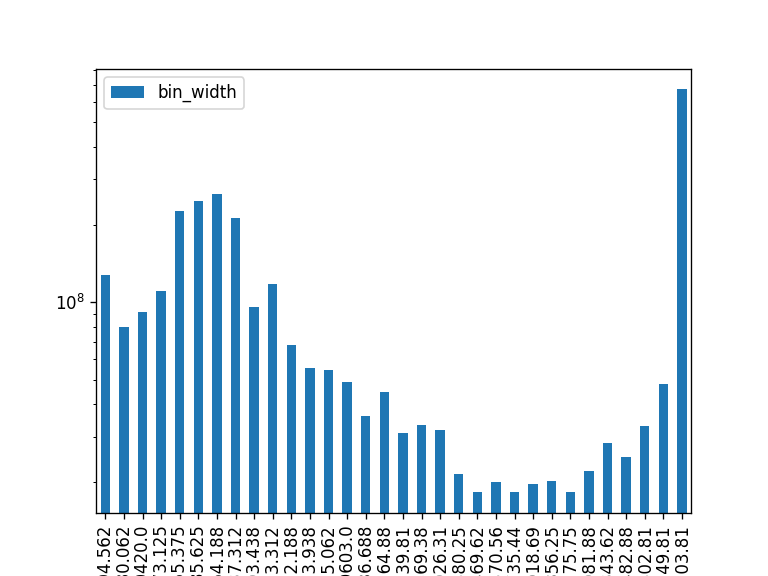

In [12]:
mid_downstream_df = (downstream_bin_info_df['min_rtt'] + downstream_bin_info_df['bin_width'] // 2).rename('mid_downstream')
bin_width_mid_downstream_df = pd.concat([downstream_bin_info_df['bin_width'], mid_downstream_df], axis=1)
bin_width_mid_downstream_df.plot.bar('mid_downstream', 'bin_width', logy=True)

<IPython.core.display.Javascript object>


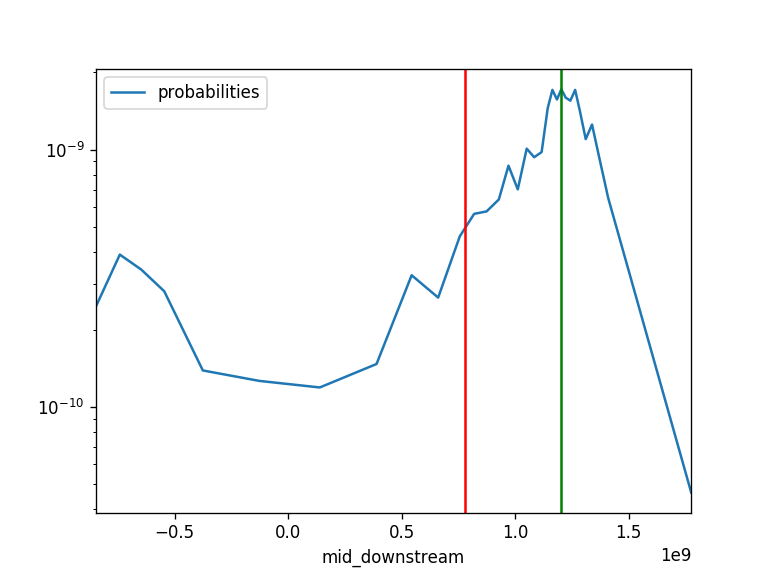

In [14]:
downstream_mode, downstream_threshold = analysis.get_mode_and_threshold(downstream_histogram, downstream_time_key_function)
downstream_probabilities_df = pd.DataFrame(analysis.get_bins_probabilities(downstream_histogram, downstream_time_key_function), 
                                columns=['probabilities'])
probabilities_per_mid_downstream_df = pd.concat([downstream_probabilities_df, mid_downstream_df], axis=1)
probabilities_per_mid_downstream_df.plot('mid_downstream', 'probabilities', logy=True, logx=False)
plt.axvline(downstream_mode, color='green')
plt.axvline(downstream_threshold, color='red')